In [230]:
from os.path import join, basename, splitext
from glob import glob
from dask import dataframe as dd
from matplotlib import rcParams
import pandas as pd
import dask
from collections import Counter
import pickle
import numpy as np
from datetime import datetime
import seaborn as sns

from sklearn.metrics import mean_absolute_error, median_absolute_error, mean_squared_error, r2_score
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

from deep_aqi import ROOT


pd.set_option('expand_frame_repr', False)
pd.set_option('max_rows', 24)

In [210]:
def MAPE(data):
    data = data[data['True'] > 0]
    return np.mean(np.abs(data['True'] - data.Pred) / data['True'])

In [223]:
def MdAPE(data):
    data = data[data['True'] > 0]
    return np.median(np.abs(data['True'] - data.Pred) / data['True'])

In [169]:
def shift_target(data, number_of_days=1):
    timeshift = data.loc[:, target_column].reset_index()
    timeshift['PredictTime'] = timeshift.LocalDate
    timeshift.PredictTime = timeshift.PredictTime + pd.Timedelta(f'{number_of_days}D')
    timeshift = timeshift.rename(columns={target_column: f'{target_column}-{number_of_days*24}h'})
    timeshift.drop('LocalDate', axis=1, inplace=True)
    data.reset_index(inplace=True)
    data = pd.merge(data, timeshift, left_on='LocalDate', right_on='PredictTime', how='left')
    data.drop('PredictTime', axis=1, inplace=True)
    return data.sort_values('LocalDate').set_index('LocalDate')

In [263]:
def clean_outliers(data, sigma=10):
    # according to chebyshev inequality 10sigma covers 99% percent of data despite the distribution
    top = data[target_column].mean() + sigma * data[target_column].std()
    return data.loc[data[target_column] < top]

In [121]:
PROCESSED_DATA = join(ROOT, 'data', 'processed')
INTERIM_DATA = join(ROOT, 'data', 'interim')
RAW_DATA = join(ROOT, 'data', 'raw')

In [122]:
file_path = join(PROCESSED_DATA, '88101.parquet')

data_source = pd.read_parquet(file_path)
target_column = data_source.columns[-1]

In [264]:
to_concat = []
prediction_dicts = {}
for site_code, df in data_source.groupby(by='SiteCode'):
    df = clean_outliers(df)
    
    df = df.sort_values('LocalDate').set_index('LocalDate')
    
    df = shift_target(df, number_of_days=1)
    df = shift_target(df, number_of_days=2)
    df.dropna(inplace=True)
    
    Y = df.loc[:, target_column]
    X = df.drop([target_column, 'SiteCode'], axis=1)
    Y = MinMaxScaler().fit_transform(Y.values.reshape(-1, 1))
    Y = pd.Series(Y.flatten(), index=X.index)    
    
    SPLIT_POINT = int(0.8 * len(df))
    X_train, X_test = X.iloc[:SPLIT_POINT, :], X.iloc[SPLIT_POINT:, :]
    y_train, y_test = Y[:SPLIT_POINT], Y[SPLIT_POINT:]

    model = GradientBoostingRegressor()

    model.fit(X_train, y_train)

    y_pred = model.predict(X_test)

    mae = mean_absolute_error(y_test, y_pred)
    mse = mean_squared_error(y_test, y_pred)
    mdae = median_absolute_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    mean = np.mean(y_test)
    
    y_test = pd.DataFrame(y_test, columns=['True']).reset_index(drop=False)  
    y_pred = pd.DataFrame(y_pred, columns=['Pred'])    
    prediction = pd.concat([y_test, y_pred], axis=1).set_index('LocalDate')
    
    mape = MAPE(prediction)
    mdape = MdAPE(prediction)

    result = pd.DataFrame(index = [site_code],
                          data={'MAE': mae,
                                'MSE': mse,
                                'MdAE': mdae,
                                'R2': r2,
                                'MAPE': mape,
                                'MdAPE': mdape,
                                'MEAN': mean,
                               })
    to_concat.append(result)
    prediction_dicts[site_code] = prediction
results = pd.concat(to_concat)

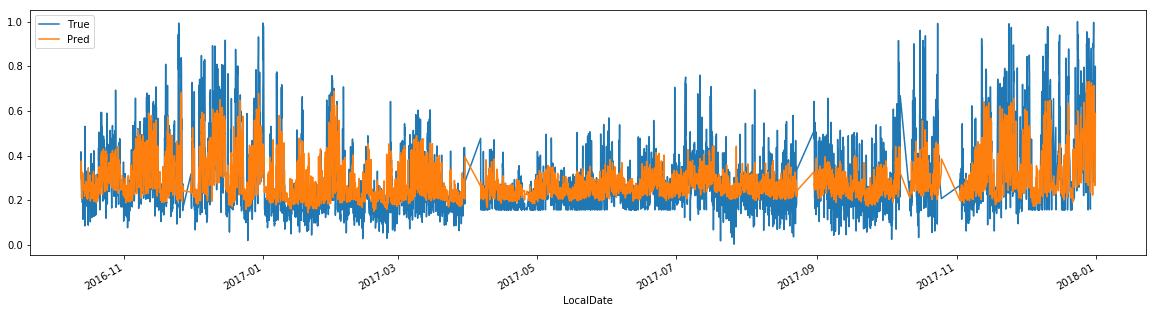

In [265]:
prediction = prediction_dicts['Nevada_Clark_540.0']
prediction.plot(figsize=(20, 5))

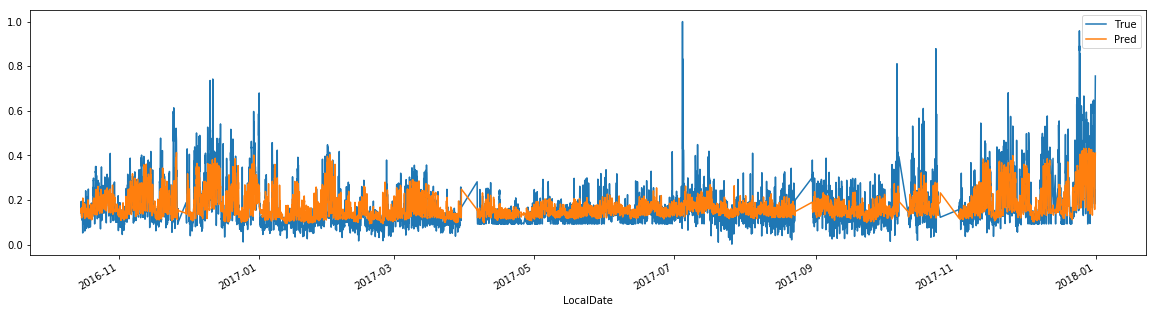

In [262]:
prediction = prediction_dicts['Nevada_Clark_540.0']
prediction.plot(figsize=(20, 5))

In [266]:
results.sort_values('R2')

,MAE,MSE,MdAE,R2,MAPE,MdAPE,MEAN
Vermont_Chittenden_7.0,0.089745,0.014237,0.069779,-0.347652,0.155463,0.138334,0.536943
North Dakota_Cass_1004.0,0.078394,0.011408,0.059607,-0.036319,0.206763,0.160570,0.391701
Missouri_Jefferson_19.0,0.075587,0.009266,0.063787,-0.026164,0.322620,0.204440,0.306460
Vermont_Bennington_4.0,0.074353,0.009255,0.061115,-0.018574,0.235866,0.171463,0.355976
Missouri_Clay_5.0,0.071737,0.008391,0.060116,0.007357,0.311003,0.186661,0.318955
Maryland_Montgomery_3001.0,0.080387,0.010276,0.068353,0.010131,0.312381,0.212420,0.316037
Maryland_Garrett_2.0,0.085256,0.011870,0.070827,0.104176,0.250803,0.183275,0.382348
New Hampshire_Hillsborough_5001.0,0.079829,0.010417,0.066518,0.105930,0.316325,0.207022,0.312869
Missouri_St. Louis City_85.0,0.066032,0.007357,0.054220,0.118755,0.257891,0.186424,0.298237
Wisconsin_Dodge_1.0,0.082804,0.011356,0.066303,0.138527,0.330079,0.252698,0.285142


In [246]:
results.sort_values('R2')

,MAE,MSE,MdAE,R2,MAPE,MdAPE,MEAN
Wisconsin_Dodge_1.0,0.004077,0.000044,0.003044,-0.626832,0.350177,0.258673,0.012898
Vermont_Chittenden_7.0,0.062744,0.007077,0.048536,-0.344872,0.157011,0.138911,0.370503
Missouri_Jefferson_19.0,0.024451,0.000995,0.020510,-0.056446,0.323315,0.203313,0.098445
Vermont_Bennington_4.0,0.059577,0.005949,0.048121,-0.023051,0.235778,0.170275,0.285090
North Dakota_Cass_1004.0,0.026521,0.001391,0.019953,-0.017428,0.209097,0.158200,0.131984
Missouri_Clay_5.0,0.012809,0.000352,0.010409,0.014649,0.315634,0.189438,0.054966
Maryland_Montgomery_3001.0,0.030688,0.001519,0.026111,0.028894,0.314099,0.212937,0.119981
Missouri_St. Louis City_85.0,0.005381,0.000053,0.004371,0.096057,0.262383,0.190013,0.023814
New Hampshire_Hillsborough_5001.0,0.035066,0.002201,0.029025,0.099525,0.316382,0.209660,0.135751
Maryland_Garrett_2.0,0.069437,0.007883,0.057523,0.109351,0.251722,0.180707,0.311616
